# Calibrate Cremat Preamp + Shaper

See ./picoScopeControl for implementation of functions. picosdk required. run

 `python -m pip install . `

_after_ installing the picosdk on the system

## Open Device (only do once)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from picoScopeControl import *
from pprint import pprint
chandle = openDevice()
pprint(rangeMap)

Opening unit
Sucess
{0.01: 0,
 0.02: 1,
 0.05: 2,
 0.1: 3,
 0.2: 4,
 0.5: 5,
 1: 6,
 2: 7,
 5: 8,
 10: 9,
 20: 10,
 50: 11}


### Configure metadata
Set accordingly. Will be put in plot as annotation and in file name

In [4]:
metadata = {
    "switchconfig" : "11",
    "stacknum" : 1
}

## Test Measurement and Fit

Setting square wave f=90 hz, A=0.2 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=8
Enabling channel 3
Triggering on 4
Done



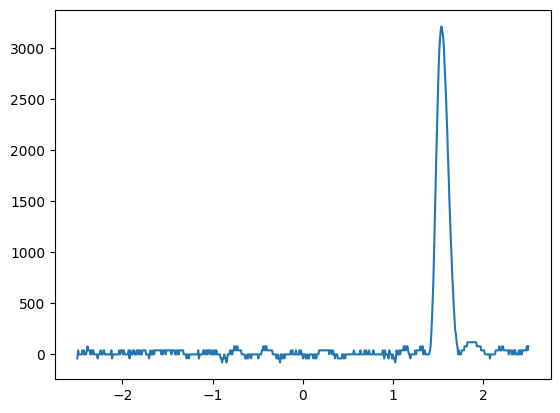

[-39.67765748031496, 39.67765748031496, 0.0, 0.0, 0.0, 0.0, 0.0, 39.67765748031496, 0.0, 39.67765748031496, 0.0, 0.0, 0.0, 39.67765748031496, 79.35531496062993, 39.67765748031496, 39.67765748031496, 39.67765748031496, 0.0, 39.67765748031496, 0.0, 39.67765748031496, 39.67765748031496, 0.0, 0.0, 0.0, 0.0, 0.0, -39.67765748031496, 0.0, 0.0, 0.0, 39.67765748031496, 0.0, 0.0, 0.0, 39.67765748031496, 39.67765748031496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.67765748031496, -39.67765748031496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.67765748031496, 0.0, 39.67765748031496, 39.67765748031496, 39.67765748031496, 0.0, 39.67765748031496, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 39.67765748031496, -39.67765748031496, 39.67765748031496, 0.0, 0.0, 0.0, 39.67765748031496, 39.67765748031496, 0.0, 0.0, 0.0, 39.67765748031496, 0.0, 39.67765748031496, 39.67765748031496, 0.0, 39.67765748031496, 0.0, 0.0, 39.67765748031496, 39.67765748031496, 39.67765748031496, 39.67765748031496, 39.67765748031496, 0.

In [5]:
A = .2 # amplitude of square pulse 
channel = 3

t, data = takeDataVal(chandle, A, rangeMap[5] , trigger=0, window=5e-6, channel=channel) # Send a test pulse of amplitude 0.5V, get data, and show plot.
#pps, errs = fitGaussian(t, data) # Fit to gauss
plt.plot(t, data)
#plt.plot(t, gauss(t, *pps))
plt.show()
print(data)

## Run Measurements

Setting square wave f=90 hz, A=0.01 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=4
Enabling channel 3
Triggering on 4
Done

Setting square wave f=90 hz, A=0.024 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=4
Enabling channel 3
Triggering on 4
Done

Maxed out range
Signal out of range, increasing max range to +- 0.5 V

Setting square wave f=90 hz, A=0.024 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=5
Enabling channel 3
Triggering on 4
Done

Setting square wave f=90 hz, A=0.039 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=5
Enabling channel 3
Triggering on 4
Done

Maxed out range
Signal out of range, increasing max range to +- 1 V

Setting square wave f=90 hz, A=0.039 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=6
Enabling channel 3
Triggering on 4
Done

Setting square wave f=90 hz, A=0.053 V
a
Sampling Data. Channel=3, trigger=0mV, window=5e-06, range=6
Enabling channel 3
Triggering on 4
Done

Set

35it [00:00, 425.27it/s]


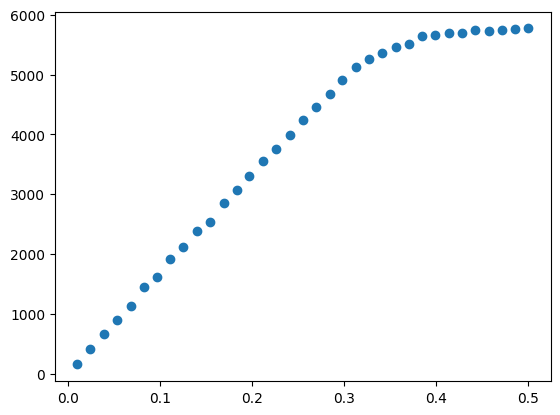

In [12]:
# input_vs = np.round(np.linspace(.01, 4, 35), 3) # gain = 00 or 01
input_vs = np.round(np.linspace(.01, .5, 35), 3) # gain = 11

#trigger_mv = 200 #trigger
trigger_mvs = 0 #trigger or list of triggers, NOTE must be in mv


window = 5e-6 #seconds, width of capture


initRange = 4 #inial voltage range for device
t, datas = getSamples(chandle,input_vs, initRange, trigger_mvs, window) # sweep input voltages and take all data points
#plotSample(t, data)
gains, gains_err = getGains(t, datas)
plt.scatter(input_vs, gains)

## Create Plot

In [13]:
#SATURATION_PT = 100 #100 means no saturation seen
indicies = np.where(np.asarray(gains) > 5000)[0]
saturation_index = indicies[0] if len(indicies) > 0 else len(input_vs)

Gain w/ error: 16.7+/-1.7


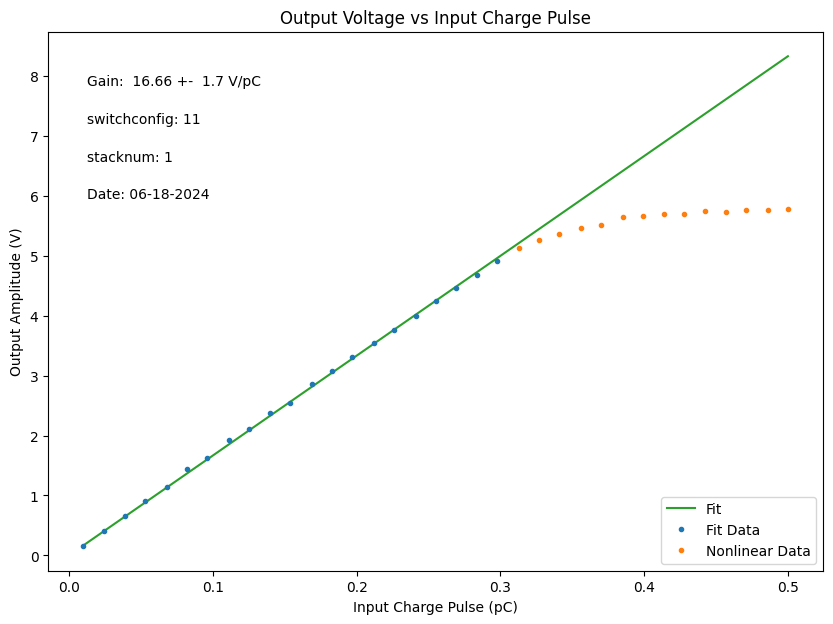

In [14]:
from uncertainties import ufloat
## DATE
from datetime import datetime
now = datetime.now() # current date and time
datestr = now.strftime("%m-%d-%Y")

## Convert units
input_charges = input_vs * 1 #times 1 pF, convert to pF
output_V = np.asarray(gains) * 1e-3 #mV to V
output_err = np.asarray(gains_err) * 1e-3

## Fit linear function
linear = lambda x, m: m*x
pps, cov = curve_fit(linear, input_charges[0:saturation_index], output_V[0:saturation_index])
perr = np.sqrt(np.diag(cov))


#DEAL WITH UNITS AND ERROR
gain = ufloat(pps[0], perr[0]) #V/V
capacitance = ufloat(1, .1) #pF, += 10%
print("Gain w/ error:", gain/capacitance)



## Plot
plt.figure(figsize=(10, 7))

plt.errorbar(input_charges[0:saturation_index], output_V [0:saturation_index],capsize=3, fmt=".", ecolor="blue",
             label="Fit Data")
plt.errorbar(input_charges[saturation_index:], output_V [saturation_index:],capsize=3, fmt=".", ecolor="orange",
             label="Nonlinear Data")
plt.plot(input_charges, linear(input_charges, *pps), label="Fit")

plt.title("Output Voltage vs Input Charge Pulse")
plt.xlabel("Input Charge Pulse (pC)")
plt.ylabel("Output Amplitude (V)")
plt.legend(loc="lower right")


## annotations
x = .05
y = .9
y_spacing = 0.07

# Gain label
plt.annotate(f"Gain: {pps[0] : .4g} +- {(gain/capacitance).s: .2g} V/pC", (x, y), xycoords="axes fraction")


# Label all metadata fields
for item in metadata.keys():
    y -= y_spacing #shift text down
    plt.annotate(f"{item}: {metadata[item]}", (x, y) , xycoords="axes fraction") 

# label date of calibration
y -= y_spacing
plt.annotate(f"Date: {datestr}", (x, y) , xycoords="axes fraction")

## give file unique name, save to png and svg
out_name = f"out-{datestr}-{metadata['stacknum']}-{metadata['switchconfig']}"
# for key in metadata.keys():
#     out_name += f"-{metadata[key]}"
    
plt.savefig(f"./out/{out_name}.svg") # svg

plt.savefig(f"./out/{out_name}.png") # png


plt.show()

## Close Unit (do once at the end)

In [192]:
from picosdk.ps3000a import ps3000a as ps
print("Closing Unit")
# Closes the unit
status = ps.ps3000aCloseUnit(chandle)
assert_pico_ok(status)

print("Closed")

Closing Unit
Closed
